<a href="https://colab.research.google.com/github/ianbernardino/Quantitative-Finance-Models/blob/master/FinanceCode_CAPM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LIBRARIES**

In [1]:
# Import libraries

import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format # Define the number style
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn') # Define plot style
# plt.rcParams['axes.facecolor'] = 'white' # Define plots background color
import seaborn as sns
!pip install yfinance --upgrade --no-cache-dir # Yahoo Finance Installation
import yfinance as yf
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=8bc81351584e75ddad32711c4ed436d8021589380ccb9d81d9a88622d9d74957
  Stored in directory: /tmp/pip-ephem-wheel-cache-nn27g6bt/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


# **INPUT VARIABLES**

In [4]:
# Define Risk Free Asset (CDI) Return and Risk

# Taxa Anual
rf_return = 0.029
rf_risk = 0
rf = [rf_return, rf_risk]

# Taxa Diária
exp = (rf_return ** 1/252)
rfd_ret = (1 + exp) -1
rfd = [rfd_ret, rf_risk]

# Define input variable of stock ticker

ticker = ["ITUB4.SA", "BBDC4.SA", "PETR4.SA", "VALE3.SA", "B3SA3.SA", "^BVSP"]

print("Company ticker: ",ticker)

Company ticker:  ['ITUB4.SA', 'BBDC4.SA', 'PETR4.SA', 'VALE3.SA', 'B3SA3.SA', '^BVSP']


# **DATA MODEL**

In [5]:
# import constituents
# Train =  start = "2011-01-01", end="2017-08-29"
# test = start = "2017-08-30", end="2020-06-30"
stocks = yf.download(ticker, start = "2011-01-01")

# Select Closing Prices

stocks = stocks["Close"].copy().dropna()

# Rename columns

stocks.columns = ["B3", "BBDC4", "ITUB4", "PETR4", "VALE3", "BVSP"]

stocks.head()

[*********************100%***********************]  6 of 6 completed


,B3,BBDC4,ITUB4,PETR4,VALE3,BVSP
Date,,,,,,
2011-05-09,12.070,13.453,16.757,24.247,50.080,"64,622.000"
2011-05-19,11.010,12.871,15.773,23.640,48.540,"62,367.000"
2011-05-20,11.020,12.871,15.732,23.990,48.750,"62,597.000"
2011-05-23,11.000,12.884,15.664,23.600,48.700,"62,345.000"
2011-05-24,11.030,13.134,15.992,23.850,49.160,"63,337.000"


Text(0, 0.5, 'Cumulative Returns')

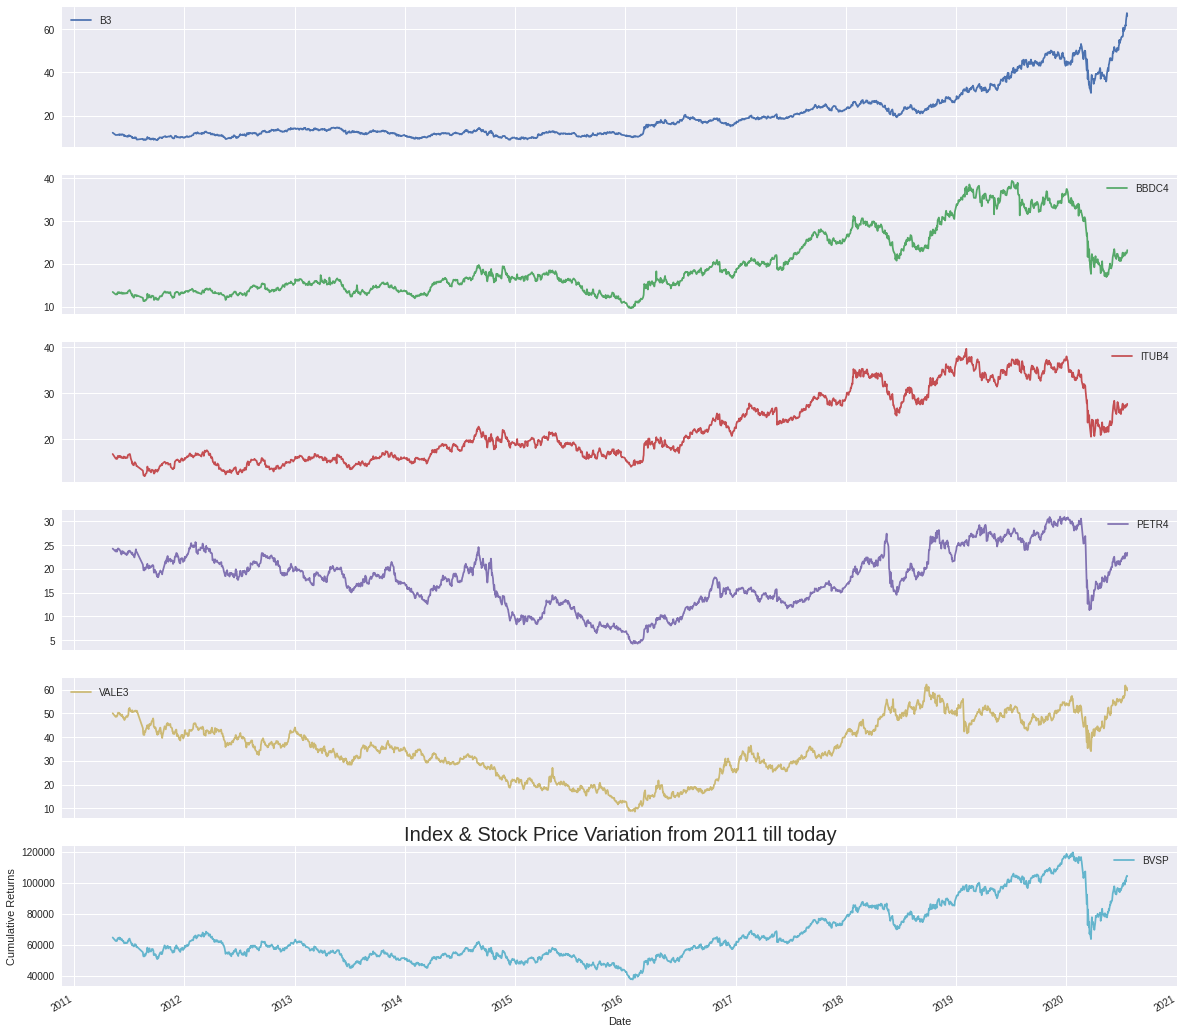

In [8]:
# Normalized series of Prices

norm = stocks.div(stocks.iloc[0].mul(100))

# Plot Time Series

stocks.plot(figsize=(20,20), subplots = True)
plt.title("Index & Stock Price Variation from 2011 till today", fontsize = 20)#, color = "white")
plt.xlabel('Date')#, color = "white")
plt.ylabel("Cumulative Returns")#, color = "white")


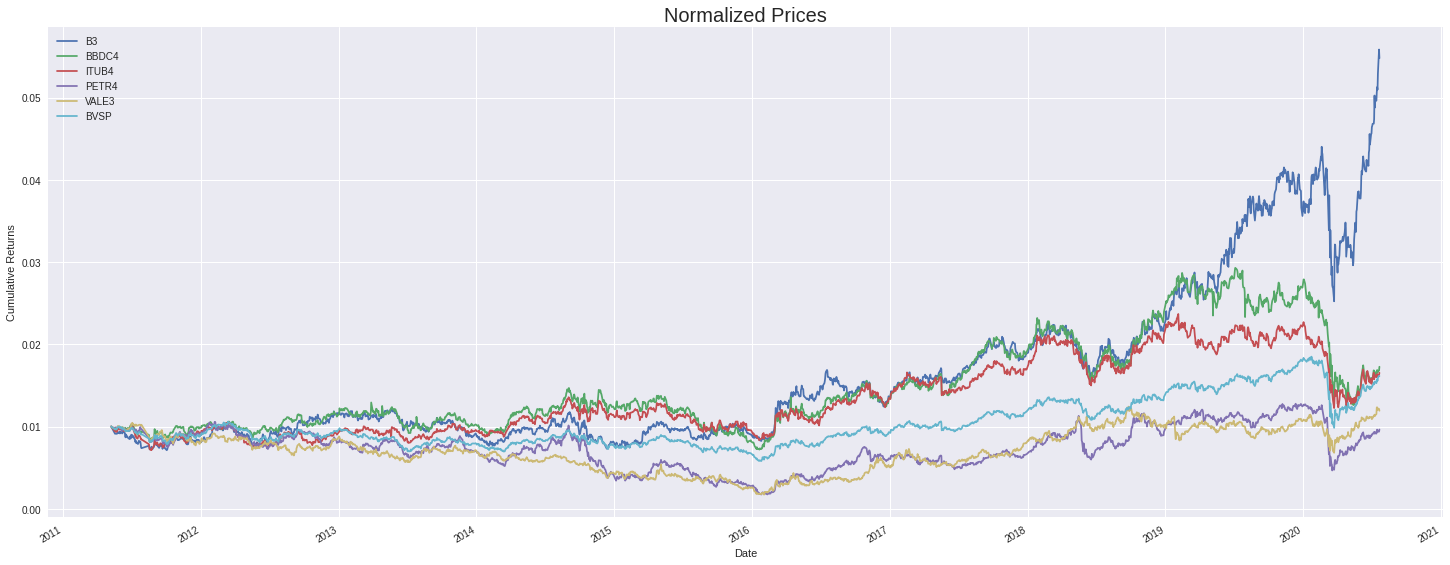

In [9]:
norm.plot(figsize=(25,10))
plt.title("Normalized Prices", fontsize = 20)#, color = "white")
plt.xlabel('Date')#, color = "white")
plt.ylabel("Cumulative Returns")#, color = "white")
plt.legend()
plt.show()

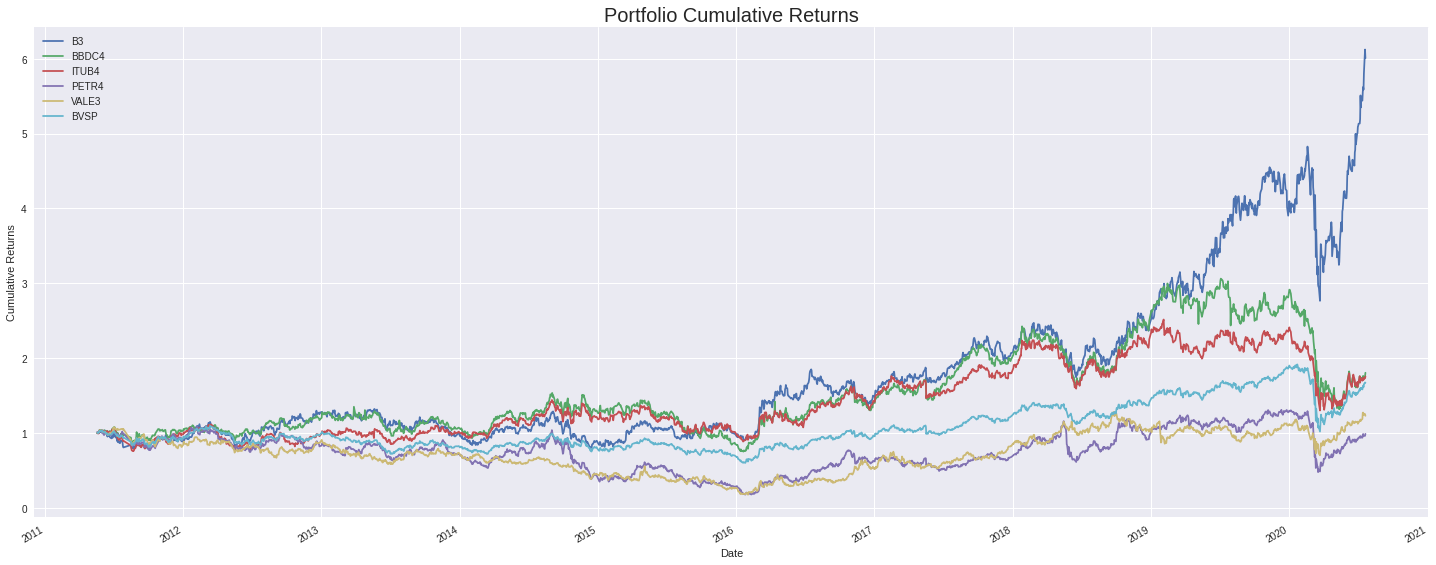

In [10]:
# Calculate returns of stock and Market Portfolio represented by BVSP and remove firt NA row

ret = stocks.pct_change().dropna()

# Calculate Cumulative Returns for constituents

cumulative_ret = ret[1:]
cumulative_ret = (cumulative_ret + 1).cumprod()

# Plot Cumulative Returns

cumulative_ret.plot(figsize=(25,10))
plt.xlabel('Date')#, color = "white")
plt.ylabel("Cumulative Returns")#, color = "white")
plt.title("Portfolio Cumulative Returns", fontsize = 20)#, color = "white")
plt.show()

In [11]:
cumulative_ret

,B3,BBDC4,ITUB4,PETR4,VALE3,BVSP
Date,,,,,,
2011-05-20,1.001,1.000,0.997,1.015,1.004,1.004
2011-05-23,0.999,1.001,0.993,0.998,1.003,1.000
2011-05-24,1.002,1.020,1.014,1.009,1.013,1.016
2011-05-25,1.010,1.011,1.003,1.011,1.015,1.016
2011-05-26,1.005,1.041,1.036,1.024,1.031,1.028
...,...,...,...,...,...,...
2020-07-15,5.621,1.764,1.740,0.987,1.273,1.632
2020-07-16,5.586,1.733,1.711,0.961,1.239,1.612
2020-07-17,5.803,1.741,1.726,0.962,1.258,1.650


In [12]:
# Define a function to calculate:
# RISK in Standard Deviation Units
# RETURN as Mean

def ann_risk_ret(return_df):
  summary = return_df.agg(["mean", "std"]).T
  summary.columns = ["Return", "Risk"]
  summary.Return = summary.Return * 252
  summary.Risk = summary.Risk * np.sqrt(252)
  return summary

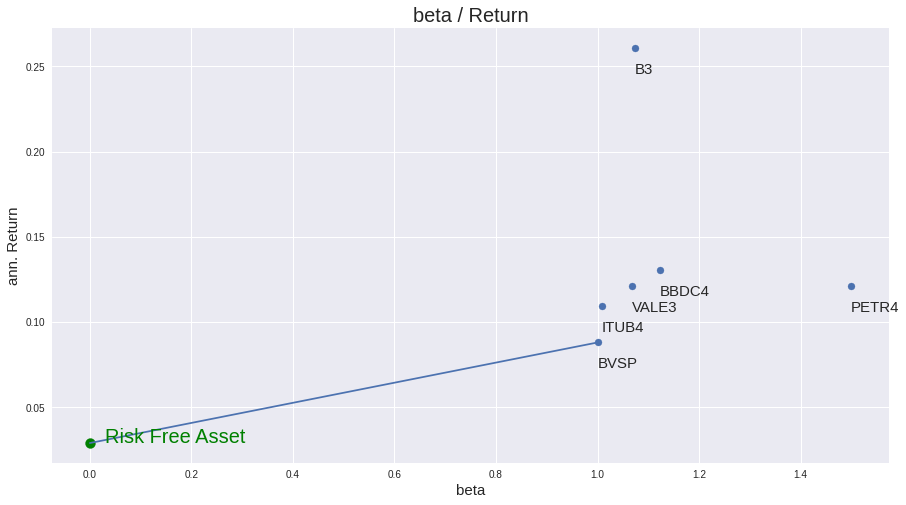

,Return,Risk,Sharpe,Total Risk_variance,SystRisk_var,beta,CAPM,alpha
B3,0.261,0.374,0.620,0.140,0.073,1.073,0.092,0.169
BBDC4,0.131,0.372,0.273,0.139,0.076,1.123,0.095,0.035
ITUB4,0.109,0.325,0.247,0.106,0.069,1.008,0.088,0.021
PETR4,0.121,0.498,0.185,0.248,0.102,1.499,0.117,0.004
VALE3,0.121,0.450,0.205,0.202,0.073,1.068,0.092,0.029
BVSP,0.088,0.261,0.226,0.068,0.068,1.000,0.088,0.000


In [13]:
#For this calculated "Max SR - MP" we create a new column for out returns dataframe with dot method

summary = ann_risk_ret(ret)
summary["Sharpe"] = (summary["Return"].sub(rf[0])) / summary["Risk"]

# variance = teta²

summary["Total Risk_variance"] = np.power(summary.Risk,2)

#Create covariance matrix for annualized returns

COV = ret.cov()*252

#Systematic Risk]

summary["SystRisk_var"] = COV.iloc[:,-1]

#Normalize, in respect to variance of the market portfolio, the Systematic Risk, so MP = 1.

summary["beta"] = summary.SystRisk_var / summary.loc["BVSP", "SystRisk_var"]

# Estimated returns of CAPM

summary["CAPM"] = rf[0] + (summary.loc["BVSP", "Return"] - rf[0]) * summary.beta

# Calculate Alpha, the deviance between the real returns and estimated returns

summary["alpha"] = summary.Return - summary.CAPM

# Plot the BETA's for all constituents in comparison with market portfolio and risk free asset

plt.figure(figsize = (15, 8))
plt.scatter(summary.beta, summary.Return)
for i in summary.index:
    plt.annotate(i, xy=(summary.loc[i, "beta"]+0.00, summary.loc[i, "Return"]-0.015), size = 15)
plt.plot([rf[1], summary.loc["BVSP", "beta"]], [rf[0], summary.loc["BVSP", "Return"]])
plt.scatter(rf[1], rf[0], s = 100, marker = "o", c = "green")
plt.annotate("Risk Free Asset", xy = (rf[1] + 0.03, rf[0]), size = 20, color = "green")
plt.xlabel("beta", fontsize = 15)
plt.ylabel("ann. Return", fontsize = 15)
plt.title("beta / Return", fontsize = 20)
plt.show()


summary